In [1]:
import pandas as pd
data = pd.read_csv('./data/digit recognizor.csv')

X = data.iloc[:, 1:]
y = data.iloc[:, 0]

X.shape

(42000, 784)

这个数据量相对夸张，如果使用支持向量机和神经网络，很可能会直接跑不出来。使用KNN跑一次大概需要半个小时。
用这个数据举例，能更够体现特征工程的重要性。

## Filter过滤法

### 方差过滤 VarianceThreshold

In [2]:
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold()  # 实例化，不填参数默认方差为0
X_var0 = selector.fit_transform(X)  # 获取删除不合格特征之后的新特征矩阵

# 也可以直接写成 X = VairanceThreshold().fit_transform(X)
X_var0.shape  # (42000, 708)
pd.DataFrame(X_var0).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,...,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,188,255,94,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,191,250,253,93,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,214,218,95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18,30,137,137,192,86,72,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,86,250,254,254,254,254,217,246,151,32,0,0,0,0,0,0,0,0,0,0,0,...,254,243,70,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,76,146,254,255,254,255,146,19,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,141,139,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,254,254,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,63,254,254,62,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,220,179,6,0,0,0,0,0,0,0,0,9,77,0,0,0,0,0,0,0,0,0,0,0,...,0,0,5,206,106,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,186,159,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,209,101,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,25,130,155,254,254,254,157,30,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,103,253,253,253,253,253,253,253,253,114,2,0,0,0,0,0,0,0,0,0,0,...,253,213,90,7,0,0,0,0,0,0,0,0,0,0,0,0,1,18,129,208,253,253,253,253,159,129,90,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
selector.inverse_transform(X_var0).shape

(42000, 784)

In [7]:
import numpy as np
# X.var()#每一列的方差
X_fsvar = VarianceThreshold(np.median(X.var().values)).fit_transform(X)
X.var().values
np.median(X.var().values)
X_fsvar.shape

(42000, 392)

In [8]:
# 若特征是伯努利随机变量，假设p=0.8，即二分类特征中某种分类占到80%以上的时候删除特征
X_bvar = VarianceThreshold(.8 * (1 - 0.8)).fit_transform(X)
X_bvar.shape

(42000, 685)

#### 方差过滤对模型的影响

In [9]:
# KNN vs 随机森林在不同方差过滤效果下的对比
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import cross_val_score
import numpy as np

X = data.iloc[:, 1:]
y = data.iloc[:, 0]

x_fsvar = VarianceThreshold(np.median(X.var().values)).fit_transform(X)

##### KNN方差过滤前

```python
#======【TIME WARNING：35mins +】======#
cross_val_score(KNN(),X,y,cv=5).mean()
 
#python中的魔法命令，可以直接使用%%timeit来计算运行这个cell中的代码所需的时间
#为了计算所需的时间，需要将这个cell中的代码运行很多次（通常是7次）后求平均值，因此运行%%timeit的时间会
# 远远超过cell中的代码单独运行的时间
 
#======【TIME WARNING：4 hours】======#
%%timeit
cross_val_score(KNN(),X,y,cv=5).mean()
```

##### KNN方差过滤后

```python
#======【TIME WARNING：20 mins+】======#
cross_val_score(KNN(),X_fsvar,y,cv=5).mean()
 
#======【TIME WARNING：2 hours】======#
%%timeit
cross_val_score(KNN(),X,y,cv=5).mean()
```

##### 随机森林方差过滤前

In [10]:
%%time
cross_val_score(RFC(n_estimators=10, random_state=0), X, y, cv=5).mean()

0.9373571428571429

##### 随机森林方差过滤后

In [12]:
%%time
cross_val_score(RFC(n_estimators=10, random_state=0), X_fsvar, y, cv=5).mean()

CPU times: user 8.41 s, sys: 56.1 ms, total: 8.47 s
Wall time: 8.47 s


0.9390476190476191

### 相关性过滤

#### 卡方过滤

In [14]:
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# 假设在这里我一直我需要300个特征
X_fschi = SelectKBest(chi2, k=300).fit_transform(X_fsvar, y)
X_fschi.shape

(42000, 300)

In [15]:
%%time
cross_val_score(RFC(n_estimators=10, random_state=0), X_fschi, y, cv=5).mean()

CPU times: user 7.47 s, sys: 66.2 ms, total: 7.53 s
Wall time: 7.54 s


0.9344761904761905

<font color='red'>准确率下降了</font>

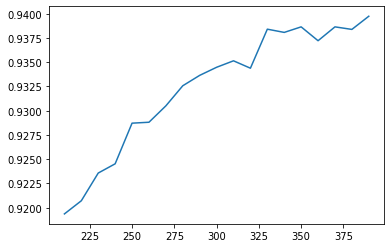

CPU times: user 2min 25s, sys: 1.22 s, total: 2min 26s
Wall time: 2min 26s


In [16]:
%%time
#======【TIME WARNING: 5 mins】======#

import matplotlib.pyplot as plt
%matplotlib inline

score = []
for i in range(390, 200, -10):
    X_fschi = SelectKBest(chi2, k=i).fit_transform(X_fsvar, y)
    once = cross_val_score(
        RFC(n_estimators=10, random_state=0), X_fschi, y, cv=5).mean()
    score.append(once)
plt.plot(range(390, 200, -10), score)
plt.show()

In [17]:
chivalue, pvalues_chi = chi2(X_fsvar, y)
chivalue

array([ 945664.84392643, 1244766.05139164, 1554872.30384525,
       1834161.78305343, 1903618.94085294, 1845226.62427198,
       1602117.23307537,  708535.17489837,  974050.20513718,
       1188092.19961931, 1319151.43467036, 1397847.8836796 ,
       1433554.26798015, 1429043.15373433, 1332663.17213405,
       1101423.25372261,  809989.56940485,  519266.71772284,
        285681.88297156,  191589.23696468,  902883.1255264 ,
       1237265.16042373, 1503477.73699155, 1625807.41495542,
       1630206.90922916, 1630597.02883804, 1633456.72909664,
       1610816.75571229, 1483382.49543886, 1256290.1574794 ,
        951236.1617682 ,  693192.66191748,  532386.96220361,
        504617.38933715,  575090.36046243,  501025.03733245,
        802341.10683194, 1078344.8724406 , 1226540.98318702,
       1269945.07968831, 1221758.57688808, 1146535.17810241,
       1080657.20185303, 1079065.30979135, 1092222.70610032,
       1064908.45385716, 1023327.00231067,  974163.15420165,
        918857.12860617,

In [18]:
pvalues_chi

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [ ]:
# k取多少？我们想要消除所有p值大于设定值，比如0.05或0.01的特征：
k = chivalue.shape[0] - (pvalues_chi)